# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [3]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
import numpy as np

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [5]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [6]:
# Import the CSVs to Pandas DataFrames
file_path_1 = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path_1, index_col="year")

file_path_2 = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path_2)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [7]:
# Getting the data from the top 10 expensive neighbourhoods
to_data_2 = pd.read_csv(file_path_1 , index_col='neighbourhood')
top10_expen_neighb = to_data_2.groupby(by=['neighbourhood']).mean()
top10_expen_neighb.sort_values(by='average_house_value', ascending=False, inplace=True)
top10_expen_neighb.reset_index(inplace=True)
top10_expen_neighb.drop(columns='year', inplace=True)

# Calculate the mean number of dwelling types units per year
avg_house_value=to_data.groupby(by='year',level=None).mean()
# Calculate the average monthly shelter costs for owned and rented dwellings
avg_monthly_shelter_costs=to_data[['shelter_costs_owned','shelter_costs_rented']].groupby(by='year',level=None).mean()

### Panel Visualization Functions

In [45]:
# Define Panel visualization functions
def neighbourhood_map():
    """neighbourhood_map"""

    each_neighbourhood = to_data.groupby(by='neighbourhood').mean()
    each_neighbourhood.reset_index(inplace=True)
    each_neighbourhood = pd.merge(df_neighbourhood_locations, each_neighbourhood, on='neighbourhood')
    px.set_mapbox_access_token(map_box_api)
    map_scatter = px.scatter_mapbox(each_neighbourhood,
    lat='lat',
    lon='lon',
    size='average_house_value',
    color='shelter_costs_rented',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    hover_name='neighbourhood',
    title='Averange House Values in Toronto',
    )
    
    plotly_panel = pn.pane.Plotly(map_scatter)
    plotly_panel._updates = True
    return plotly_panel
  


def create_bar_chart(data, title, xlabel, ylabel, color):
    
    fig=plt.figure()
    bar=data.plot.bar(color=color)
    bar.set_xlabel(xlabel)
    bar.set_ylabel(ylabel)
    bar.set_title(title)
    plt.show()
    plt.close(fig)
    
    return fig
   

def create_line_chart(data, title, xlabel, ylabel, color):
    """
    data=to_data,
    title='Average House Value',
    xlabel='Year',
    ylabel='Avg House Value',
    color='color'
    """
    
    fig=plt.figure()
    line=data.plot.line(color=color)
    line.set_xlabel(xlabel)
    line.set_ylabel(ylabel)
    line.set_title(title)
    plt.show()
    plt.close(fig)
    
    return fig

def average_house_value():
    """Average house values per year."""
    avg_monthly_shelter_costs=to_data[['shelter_costs_owned','shelter_costs_rented']].groupby(by='year',level=None).mean()

    ypoints = np.array([289882.885714,424059.664286,530424.721429,664068.328571])
    xpoints=np.array([2001,2006,2011,2016])
    fig=plt.plot(xpoints,ypoints, color = 'hotpink')
    plt.xlabel("Year")
    plt.ylabel("Avg House Value")
    plt.title("Average House Value In Toronto")
    
    
    
    return pn.pane.Matplotlib(fig)

def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""

    tor_data_new = to_data.groupby([to_data.index, 'neighbourhood']).mean()
    tor_sales = tor_data_new['average_house_value']
    tor_sales_df = pd.DataFrame(tor_sales).reset_index()
    tor_sales_df=tor_sales_df.hvplot.line('year','average_house_value',xlabel='year',ylabel='average_house_value',groupby='neighbourhood')
   
    return tor_sales_df

def number_dwelling_types():
    """Number of dwelling types per year"""

    list_dwellings = ['single_detached_house','apartment_five_storeys_plus','movable_dwelling','semi_detached_house','row_house','duplex','apartment_five_storeys_less','other_house']


    number_dwelling_types_graph=to_data.hvplot.bar('year',list_dwellings,groupby='neighbourhood',rot=90,stacked=False,xlabel='Year',ylabel='Dwelling Type Units',height=400, width=700)
    return number_dwelling_types_graph


 


def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""

    barchart=px.bar(to_data,
        x='neighbourhood',width=900,
        y='average_house_value',height=1000,
        color='average_house_value',
        orientation='v',
        facet_row=to_data.index,
        facet_row_spacing=0.001,
        title='Average House Values in Toronto per Neighbourhood',
               )
    figure = barchart
    figure.update_xaxes(categoryorder='category ascending')

    return figure

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    to_data_2 = pd.read_csv(file_path_1, index_col='neighbourhood')
    top10_expen_neighb = to_data_2.groupby(by=['neighbourhood']).mean()
    top10_expen_neighb.sort_values(by='average_house_value', ascending=False, inplace=True)
    top10_expen_neighb.reset_index(inplace=True)
    top10_expen_neighb = top10_expen_neighb.head(10)
    top10_expen_neighb.drop(columns='year', inplace=True)
    top10_expen_neighb_plot=top10_expen_neighb.hvplot.bar(x='neighbourhood',y='average_house_value',rot=90,ylim=[0,1600000],title='Top 10 Expensive Neighbourhoods',height=600, width=400)
    return top10_expen_neighb_plot

def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""

    file_path_1 = Path("Data/toronto_neighbourhoods_census_data.csv")
    to_data = pd.read_csv(file_path_1, index_col="year")
    df_expensive_neighb_year=to_data[to_data['neighbourhood'].isin(top10_expen_neighb['neighbourhood'])]
    df_expensive_neighb_year.reset_index(inplace=True)
    
    fig = px.sunburst(df_expensive_neighb_year,
                      path=["year", "neighbourhood"],
                      values='average_house_value',
                      width=750, height=750,
                      color_continuous_scale="BrBG",
                      color='shelter_costs_owned',
                      title="Costs Analysis of Most Expensive Neighbourhoods in Toronto per Year"
                      )
    return fig

In [9]:
    dwelling_types_df=to_data.groupby(by='year',level=None).sum()
    dwelling_types_df
    dwelling_types_df=pd.DataFrame(dwelling_types_df)
    dwelling_types_df.to_csv('Data/dwelling_types_df.csv')

    columns=['single_detached_house','apartment_five_storeys_plus','movable_dwelling','semi_detached_house','row_house','duplex','apartment_five_storeys_less','other_house']
    dwelling_types=dwelling_types_df[columns]

    

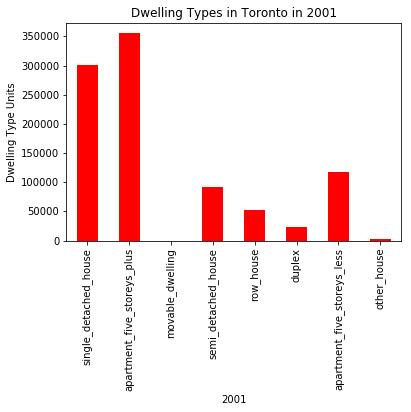

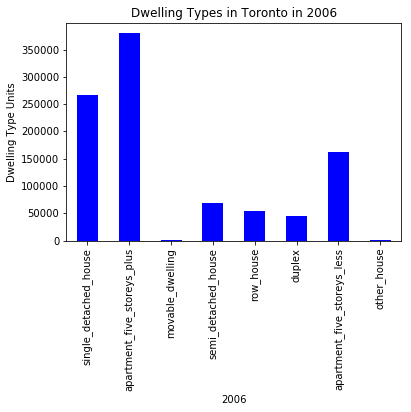

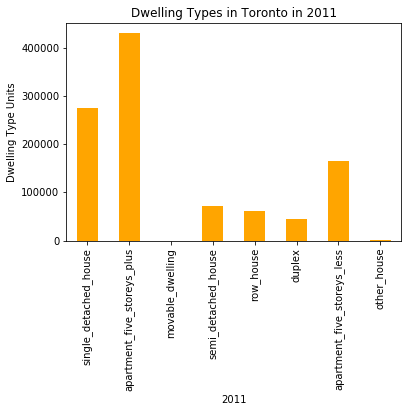

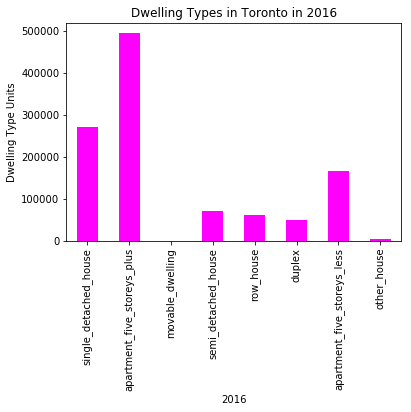

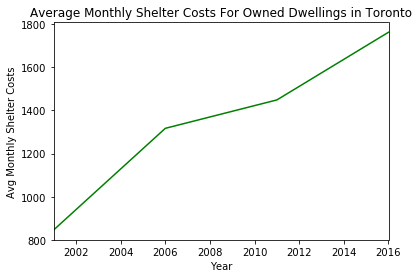

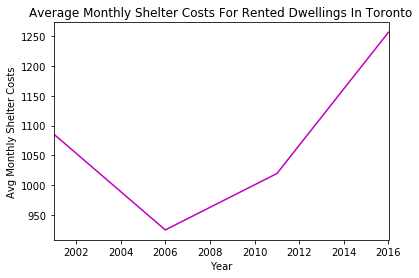

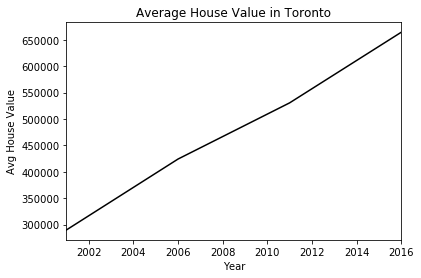

In [10]:
bar_2001=create_bar_chart(dwelling_types.loc[2001],'Dwelling Types in Toronto in 2001','2001','Dwelling Type Units','red')
bar_2006=create_bar_chart(dwelling_types.loc[2006],'Dwelling Types in Toronto in 2006','2006','Dwelling Type Units','blue')
bar_2011=create_bar_chart(dwelling_types.loc[2011],'Dwelling Types in Toronto in 2011','2011','Dwelling Type Units','orange')
bar_2016=create_bar_chart(dwelling_types.loc[2016],'Dwelling Types in Toronto in 2016','2016','Dwelling Type Units','magenta')
line_owned=create_line_chart(avg_monthly_shelter_costs['shelter_costs_owned'],'Average Monthly Shelter Costs For Owned Dwellings in Toronto','Year','Avg Monthly Shelter Costs','g')
line_rented=create_line_chart(avg_monthly_shelter_costs['shelter_costs_rented'],'Average Monthly Shelter Costs For Rented Dwellings In Toronto','Year','Avg Monthly Shelter Costs','m')
line_avg_house_value =create_line_chart(avg_house_value['average_house_value'],'Average House Value in Toronto','Year','Avg House Value','black')
                                                                                                

In [11]:
#converting bar chart and line chart functions 
bar_2001_pn = pn.pane.Matplotlib(bar_2001, tight=True)
bar_2006_pn = pn.pane.Matplotlib(bar_2006, tight=True)
bar_2011_pn = pn.pane.Matplotlib(bar_2011, tight=True)
bar_2016_pn = pn.pane.Matplotlib(bar_2016, tight=True)

line_owned_pn=pn.pane.Matplotlib(line_owned,tight=True)
line_rented_pn=pn.pane.Matplotlib(line_rented,tight=True)
line_avg_house_value_pn=pn.pane.Matplotlib(line_avg_house_value,tight=True)

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [44]:
# Create a Title for the Dashboard
title=pn.pane.Markdown('Toronto Real Estate Analysis')

# Define a welcome text
msg_text=pn.pane.Markdown('Welcome to Toronto, one of the most sought out city in the world')

#converting charts to create Dashboard

yearly_bar1 = pn.Row(bar_2001_pn, bar_2006_pn)
yearly_bar2 = pn.Row(bar_2011_pn, bar_2016_pn)
yearly_bars = pn.Column(yearly_bar1, yearly_bar2)
dwelling_value=pn.Column(line_owned_pn,line_rented_pn,line_avg_house_value_pn)
Welcome_text=pn.Column(msg_text,neighbourhood_map_pn)
most_expensive_neighbourhood=pn.Column(top_most_expensive_neighbourhoods,sunburts_cost_analysis)



Column(height=800, sizing_mode='fixed', width=1000)
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Column
                [0] Markdown(str)
                [1] Plotly(Figure)
            [1] Plotly(Figure)
        [1] Column
            [0] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [1] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Matplotlib(Figure, tight=True)
            [1] Matplotlib(Figure, tight=True)
            [2] Matplotlib(Figure, tight=True)
        [3] Column
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive02563', viewport={'xaxis.range': [-0.5, ...})
            [1] Column
                [0] Column()
                [1] Row
                    [0] Row(name='interactive02569')
                        [0] HoloViews(DynamicMap, name='interactive02569')
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                            [1] VSpacer()
            [2] Column
                [0] Column()
                [1] Row
                    [0] Row(name='interactive02613')
                        [0] HoloViews(DynamicMap, name='interactive02613')
                        [1] Column
                            [0] WidgetBox
                                [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                            [1] VSpacer()
        [4] Column
            [0] Column
                [0] Column()
                [1] Row
                    [0] HoloViews(Bars, name='interactive05519')
            [1] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive05612')
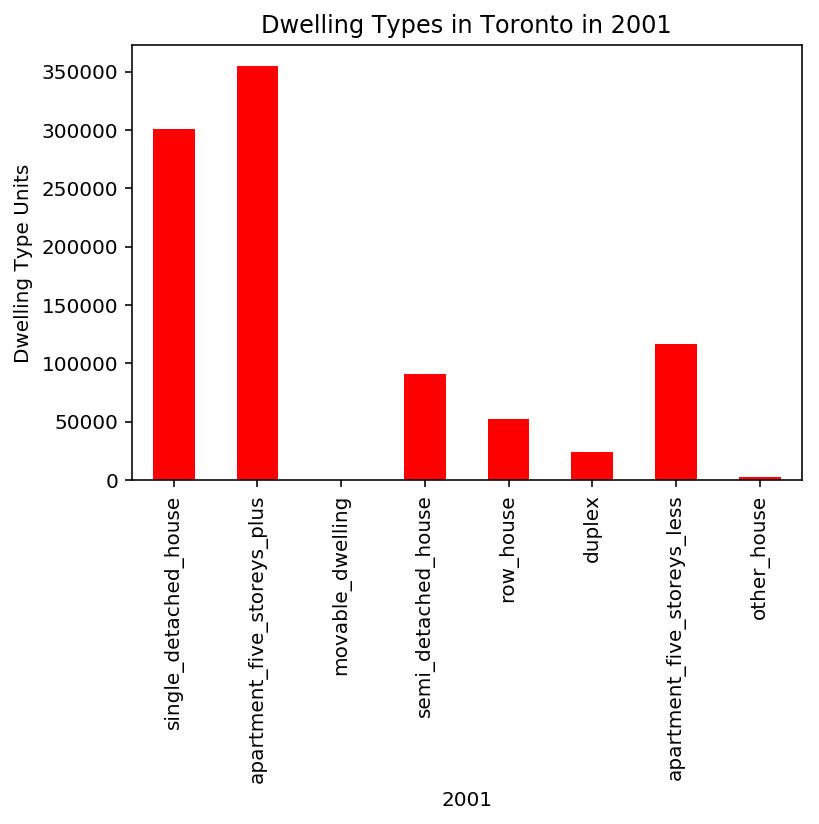
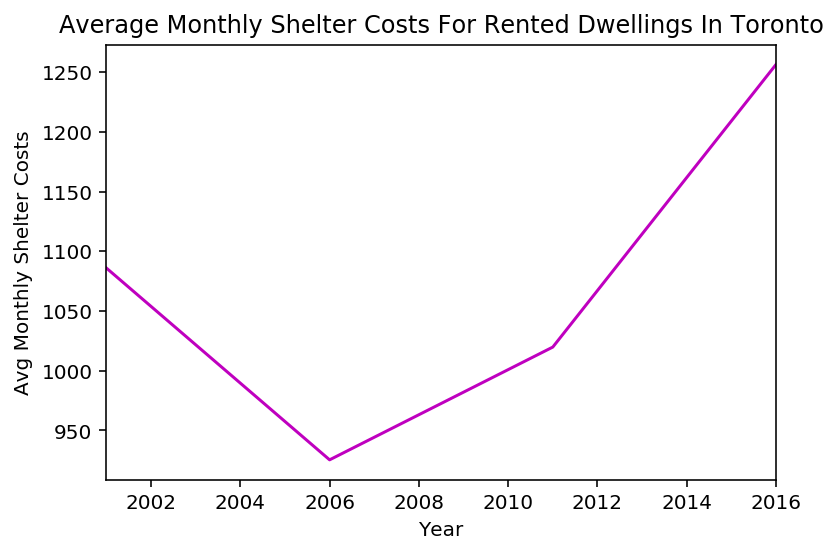
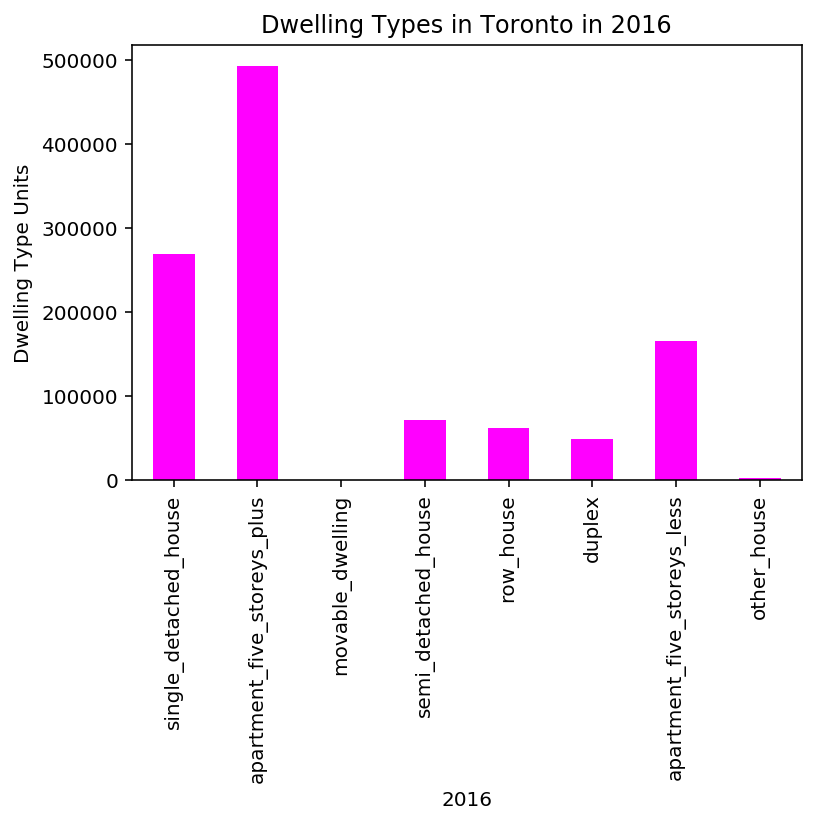
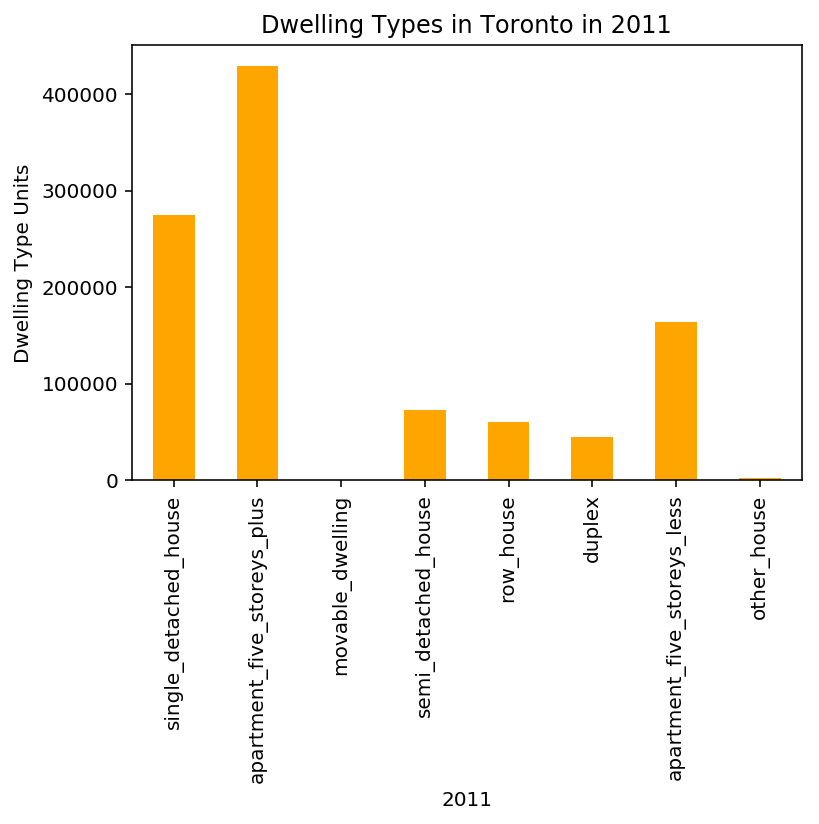
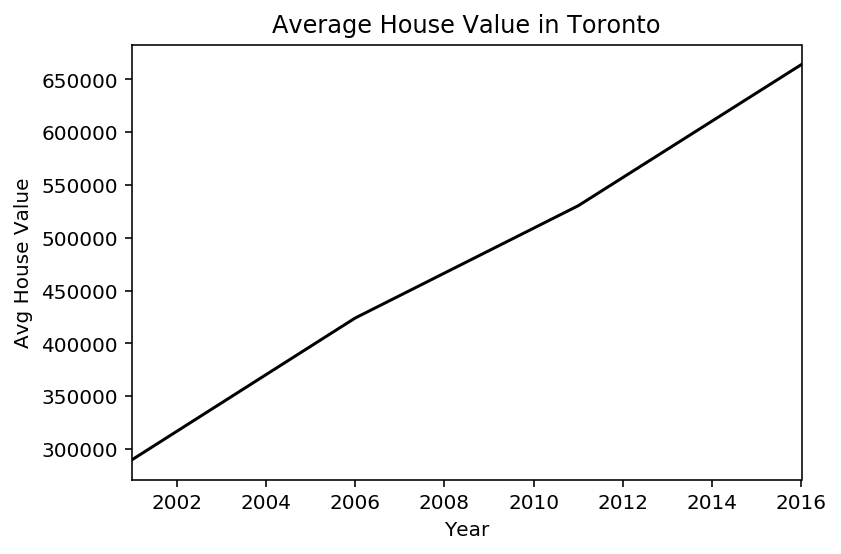
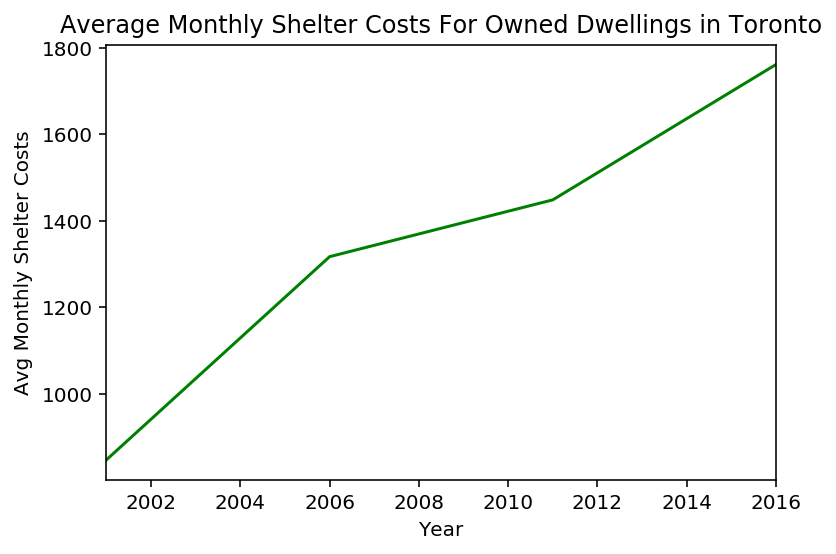
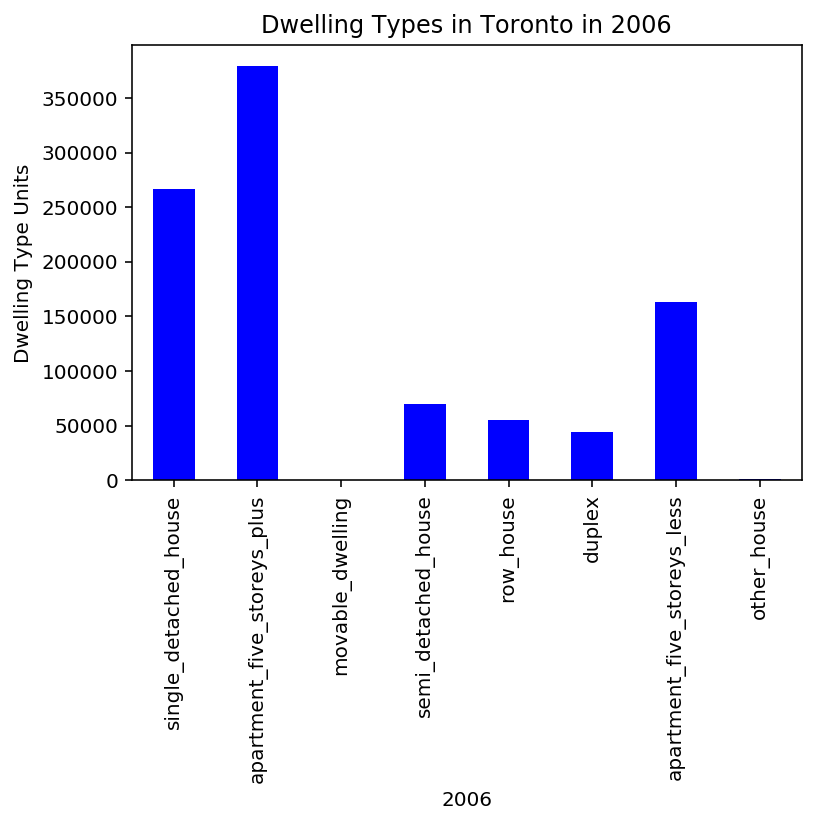

In [46]:
tabs = pn.Tabs(
    (
        "Welcome",
        pn.Column(
            Welcome_text,
            neighbourhood_map()
        )
        
    ),
('Yearly Market Analysis',yearly_bars),
('Shelter Costs VS. House Value', dwelling_value),             
('Neighbourhood Analysis',neighbourhood_dwellings_analysis),

('Top Most Expensive Neighbourhoods', most_expensive_neighbourhood))

dashboard=pn.Column(pn.Row(title),tabs,width=1000,height=800)
dashboard

## Serve the Panel Dashboard

In [ ]:
dashboard.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [ ]:
# neighbourhood_map().show()
each_neighbourhood = to_data.groupby(by='neighbourhood').mean()
each_neighbourhood.reset_index(inplace=True)
each_neighbourhood = pd.merge(df_neighbourhood_locations, each_neighbourhood, on='neighbourhood')
px.set_mapbox_access_token(map_box_api)
map_scatter = px.scatter_mapbox(each_neighbourhood,
    lat='lat',
    lon='lon',
    size='average_house_value',
    color='shelter_costs_rented',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    hover_name='neighbourhood',
    title='Averange House Values in Toronto',
)
map_scatter.show()

In [ ]:
# create_bar_chart(data, title, xlabel, ylabel, color)
dwelling_types_df=to_data.groupby(by='year',level=None).sum()
dwelling_types_df
columns=['single_detached_house','apartment_five_storeys_plus','movable_dwelling','semi_detached_house','row_house','duplex','apartment_five_storeys_less','other_house']
dwelling_types=dwelling_types_df[columns]
dwelling_types.head()

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")
fig=plt.figure()
ax=fig.add_axes([0,10,1,1])
housing_types=dwelling_types.columns
dwelling_type_units=dwelling_types.iloc[0].values
ax.bar(housing_types,dwelling_type_units,color='r')
ax.set_title('Dwelling types in Toronto 2001')
ax.set_ylabel('Dwelling Type Units')
ax.set_xlabel('2001')
plt.xticks(rotation=90)
plt.show()
# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")
fig=plt.figure()
ax=fig.add_axes([0,10,1,1])
housing_types=dwelling_types.columns
dwelling_type_units=dwelling_types.iloc[1].values
ax.bar(housing_types,dwelling_type_units,color='b')
ax.set_title('Dwelling types in Toronto 2006')
ax.set_ylabel('Dwelling Type Units')
ax.set_xlabel('2006')
plt.xticks(rotation=90)
plt.show()
# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")
fig=plt.figure()
ax=fig.add_axes([0,10,1,1])
housing_types=dwelling_types.columns
dwelling_type_units=dwelling_types.iloc[2].values
ax.bar(housing_types,dwelling_type_units,color='orange')
ax.set_title('Dwelling types in Toronto 2011')
ax.set_ylabel('Dwelling Type Units')
ax.set_xlabel('2011')
plt.xticks(rotation=90)
plt.show()
# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")
fig=plt.figure()
ax=fig.add_axes([0,10,1,1])
housing_types=dwelling_types.columns
dwelling_type_units=dwelling_types.iloc[3].values
ax.bar(housing_types,dwelling_type_units,color='m')
ax.set_title('Dwelling types in Toronto 2016')
ax.set_ylabel('Dwelling Type Units')
ax.set_xlabel('2016')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# create_line_chart(data, title, xlabel, ylabel, color)

avg_monthly_shelter_costs=to_data[['shelter_costs_owned','shelter_costs_rented']].groupby(by='year',level=None).mean()
avg_monthly_shelter_costs
# # Line chart for owned dwellings


fig=plt.figure()
line=avg_monthly_shelter_costs.plot.line(color='color')
line.set_xlabel('xlabel')
line.set_ylabel('ylabel')
line.set_title('title')

plt.show()
#plt.close(fig)



create_line_chart(avg_monthly_shelter_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

#ypoints = np.array([846.878571,1316.800000,1448.214286,1761.314286])
#xpoints=np.array([2001,2006,2011,2016])
#plt.plot(xpoints,ypoints, color = 'b')
#plt.xlabel("Year")
#plt.ylabel("Avg Monthly Shelter Costs")
#plt.title("Average Monthly Shelter Costs For Owned Dwellings In Toronto")
#plt.show()

# # Line chart for rented dwellings
create_line_chart(avg_monthly_shelter_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")
#ypoints = np.array([1085.935714,925.414286,1019.792857,1256.321429])
#xpoints=np.array([2001,2006,2011,2016])
#plt.plot(xpoints,ypoints, color = 'orange')
#plt.xlabel("Year")
#plt.ylabel("Avg Monthly Shelter Costs")
#plt.title("Average Monthly Shelter Costs For Rented Dwellings In Toronto")
#plt.show()

In [ ]:
average_house_value()
#ypoints = np.array([289882.885714,424059.664286,530424.721429,664068.328571])
#xpoints=np.array([2001,2006,2011,2016])
plt.plot(xpoints,ypoints, color = 'hotpink')
plt.xlabel("Year")
plt.ylabel("Avg House Value")
plt.title("Average House Value In Toronto")
plt.show()

In [ ]:
 average_value_by_neighbourhood()


barchart=px.bar(to_data,
        x='neighbourhood',width=900,
        y='average_house_value',height=1000,
        color='average_house_value',
        orientation='v',
        facet_row=to_data.index,
        facet_row_spacing=0.001,
        title='Average House Values in Toronto per Neighbourhood',
               )
figure = barchart
figure.update_xaxes(categoryorder='category ascending')
figure.show()

In [ ]:
number_dwelling_types()
list_dwellings = ['single_detached_house','apartment_five_storeys_plus','movable_dwelling','semi_detached_house','row_house','duplex','apartment_five_storeys_less','other_house']
to_data.hvplot.bar('year',list_dwellings,groupby='neighbourhood',rot=90,stacked=False,xlabel='Year',ylabel='Dwelling Type Units',height=400, width=700)

In [ ]:
average_house_value_snapshot()
#ypoints = np.array([289882.885714,424059.664286,530424.721429,664068.328571])
#xpoints=np.array([2001,2006,2011,2016])
plt.plot(xpoints,ypoints, color = 'hotpink')
plt.xlabel("Year")
plt.ylabel("Avg House Value")
plt.title("Average House Value In Toronto")
plt.show()

In [40]:
#top_most_expensive_neighbourhoods()
to_data_2 = pd.read_csv(file_path, index_col='neighbourhood')
top10_expen_neighb = to_data_2.groupby(by=['neighbourhood']).mean()
top10_expen_neighb.sort_values(by='average_house_value', ascending=False, inplace=True)
top10_expen_neighb.reset_index(inplace=True)
top10_expen_neighb = top10_expen_neighb.head(10)
top10_expen_neighb.drop(columns='year', inplace=True)
top10_expen_neighb_plot=top10_expen_neighb.hvplot.bar(x='neighbourhood',y='average_house_value',rot=90,ylim=[0,1600000],title='Top 10 Expensive Neighbourhoods',height=600, width=500)
top10_expen_neighb_plot

:Bars   [neighbourhood]   (average_house_value)

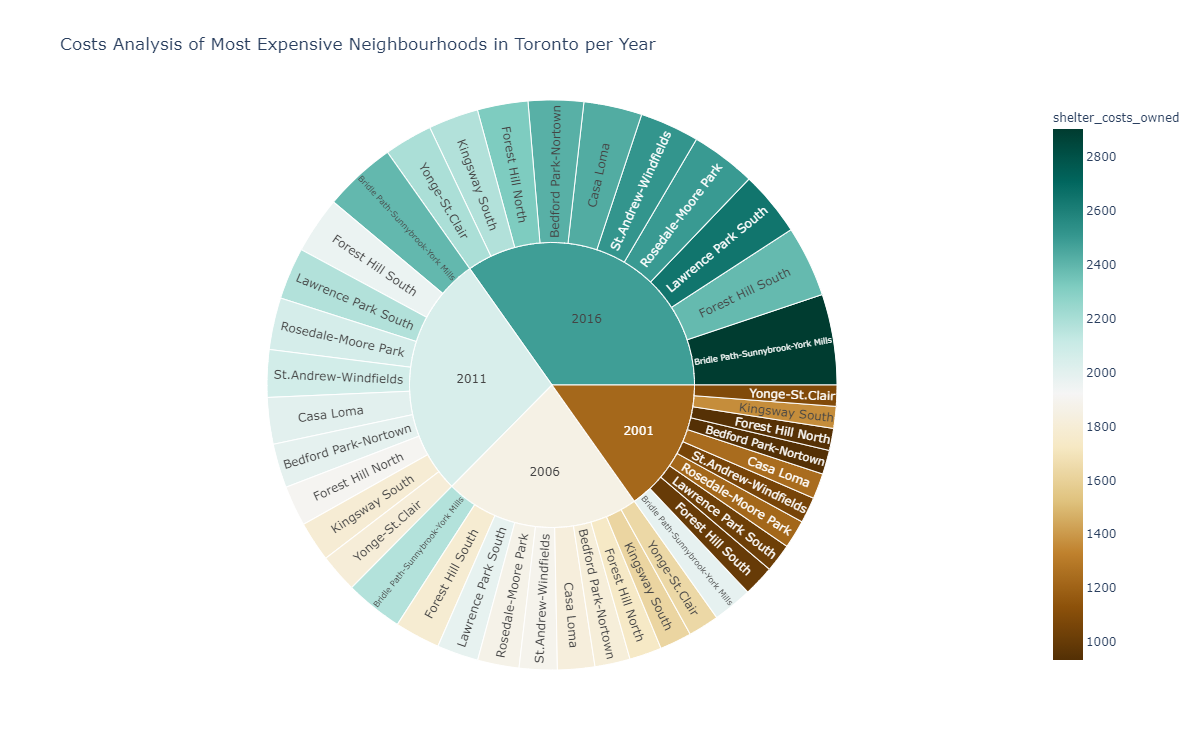

In [41]:
##sunburts_cost_analysis()


file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")
df_expensive_neighb_year=to_data[to_data['neighbourhood'].isin(top10_expen_neighb['neighbourhood'])]
df_expensive_neighb_year.reset_index (inplace=True)

fig = px.sunburst(df_expensive_neighb_year,
                  path=["year", "neighbourhood"],
                  values='average_house_value',
                  width=750, height=750,
                  color_continuous_scale="BrBG",
                  color='shelter_costs_owned',
                  title="Costs Analysis of Most Expensive Neighbourhoods in Toronto per Year"
                  )
fig.show()

